# Градиентный спуск и линейные модели

[Линейные модели](https://ru.wikipedia.org/wiki/%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F) являются наиболее простыми моделями, используемыми в машинном обучении.

Традиционно этот класс моделей в большей степени используется для решения задач регрессии.

Детально описаны в библиотеке [scikit-learn.](https://scikit-learn.org/stable/modules/linear_model.html)

Линейные модели активно используются в [рекомендуемых методах scikit-learn](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) для регрессии.


In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

## Основы метода

В основе метода лежит гипотеза, что целевой признак $y$ линейно зависит от матрицы исходных признаков $X$ ($k$ - количество признаков): $y \sim X$.

Тогда значение целевого признака $y$ можно аппроксимировать с помощью линейной функции $f(x,b)$:

$$ y = f(x,b) + \epsilon$$
$$ \hat{y} = f(x,b) $$
$$ y = \hat{y} + \epsilon$$
где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $\epsilon$ - ошибка модели


Ошибка всегда присутствует, ведь на практике нет никакой гарантии, что зависимость между исходными признаками и целевым признаком действительно линейная.

В модели линейной регресии $\hat{y} = f(x,b)$ можно представить как скалярное произведение вектора признаков (регрессоров или факторов) $x_i$ на вектор коэффициентов модели $b_i$:

$$ \hat{y} = f(x,b) = b_0 + b_1 \cdot x_1 + \dots + b_k \cdot x_k $$

Коэффициент $b_0$ (константу) можно рассматривать как коэффициент при нулевом признаке, который всегда равен 1 ($x_0=1$). Тогда:

$$ \hat{y} = f(x,b) = b_0 \cdot x_0 + b_1 \cdot x_1 + \dots + b_k \cdot x_k = \sum\limits_{i=0}^k b_i \cdot x_i = x^T b $$

Построение модели линейной регресии означает нахождение всех коэффициентов $b_i$ на основании известных значений матрицы исходных признаков $X$ и вектора целевого признака $y$ из обучающей выборки.

Фактически, нужно найти такие значения $b_i$, которые минимизируют ошибку $\epsilon$.

Значение коэффициентов $b_i$ может быть найдено:
1. аналитически
1. с использованием численных методов (что используется на практике наиболее часто)




Для удобства демонстрации метода рассмотрим частный случай с единственным регрессором: 
$$ y = \hat{y} + \epsilon$$
$$ \hat{y} = b_0 + b_1 \cdot x_1 $$

### Подготовка данных

В качестве набора данных будем использовать Boston dataset.

In [2]:
boston = load_boston()

In [3]:
df_boston = pd.DataFrame(boston.data,columns=boston.feature_names)
df_boston['target'] = pd.Series(boston.target)
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


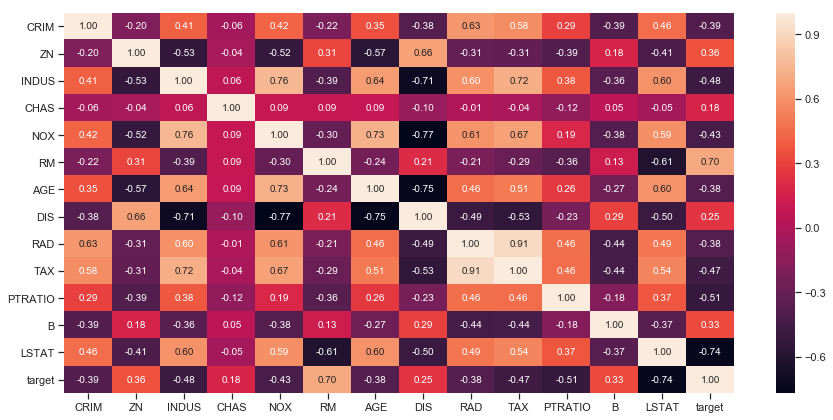

In [4]:
#Построим корреляционную матрицу
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_boston.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

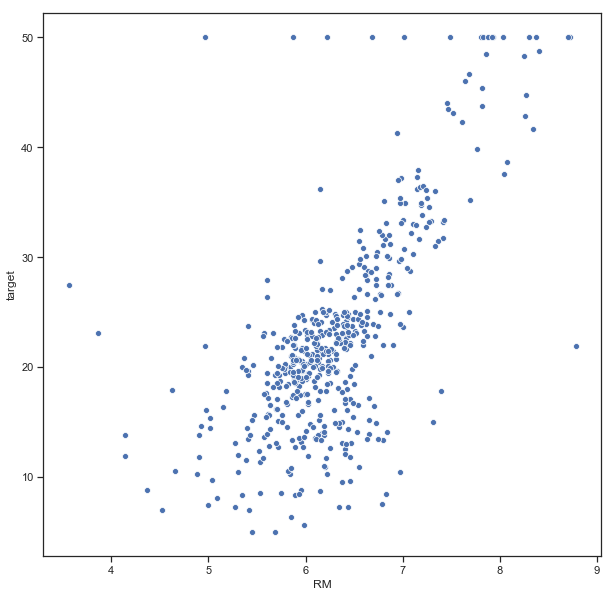

In [5]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.scatterplot(ax=ax, x='RM', y='target', data=df_boston)

Между признаком "RM" и целевым признаком "target" существует зависимость, близкая к линейной, коэффициент корреляции = 0,7

Попробуем восстановить данную линейную зависимость.

## Аналитическое восстановление зависимости

Для аналитического восстановления зависимости можно использовать следующие формулы (которые выводятся на основе рассматриваемого далее метода наименьших квадратов).

Пусть $\overline{x}$ - среднее значение для x, а $\overline{y}$ - среднее значение для y.

Тогда для средних значений рассматриваемой выборки:

$$ \overline{y} = b_0 + b_1 \overline{x} $$

Примем без вывода что:

$$ b_1 = \frac{\sum\limits_{i=1}^k (x_i - \overline{x}) \cdot (y_i - \overline{y})}{\sum\limits_{i=1}^k (x_i - \overline{x})^2} = \frac{Cov(x,y)}{Var(x)} $$

Тогда:

$$ b_0 = \overline{y} - b_1 \overline{x} $$

Вывод приведен [здесь.](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BD%D0%B0%D0%B8%D0%BC%D0%B5%D0%BD%D1%8C%D1%88%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82%D0%BE%D0%B2#%D0%9C%D0%9D%D0%9A_%D0%B2_%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B5_%D0%BB%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%BE%D0%B9_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8)

In [6]:
# Аналитическое вычисление коэффициентов регрессии
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-x_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

In [7]:
x_array = df_boston['RM'].values
y_array = df_boston['target'].values

In [8]:
b0, b1 = analytic_regr_coef(x_array, y_array)
b0, b1

(-34.67062077643857, 9.10210898118031)

In [9]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [10]:
y_array_regr = y_regr(x_array, b0, b1)

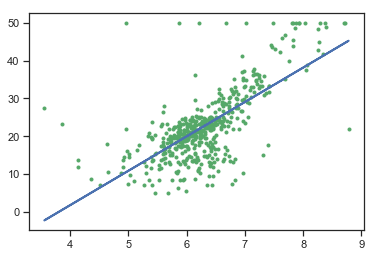

In [11]:
plt.plot(x_array, y_array, 'g.')
plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
plt.show()

## Восстановление зависимости с использованием численных методов

Смысл использования всех численных методов сводится к тому, чтобы в выражении $y = \hat{y} + \epsilon$ минимизировать ошибку $\epsilon \rightarrow min$ (или какой-либо функцию от ошибки, называемую функцией потерь - $L$), то есть насколько это возможно приблизить предсказанные значения $\hat{y}$ к действительным значениям $y$.

Одним из наиболее часто используемых методов является метод наименьших квадратов.

### [Метод наименьших квадратов](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BD%D0%B0%D0%B8%D0%BC%D0%B5%D0%BD%D1%8C%D1%88%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82%D0%BE%D0%B2)

В методе наименьших квадратов в качестве функции потерь используется квадрат ошибки $\epsilon^2$.

Решается задача оптимизации:

$$ L = \epsilon^2 \rightarrow min = \sum\limits_{i=1}^k \epsilon_i^2 \rightarrow min = \sum\limits_{i=1}^k (y_i - \hat{y}_i)^2 \rightarrow min $$

Проиллюстрируем метод наименьших квадратов. Для первых 10 точек покажем ошибки между истинными и предсказанными значениями:

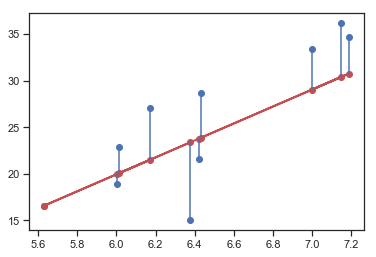

In [12]:
# Синими отрезками показаны ошибки между 
# истинными и предсказанными значениями
plt.plot(x_array[1:11], y_array[1:11], 'bo')
plt.plot(x_array[1:11], y_array_regr[1:11], '-ro', linewidth=2.0)

for i in range(len(x_array[1:11])):
    x1 = x_array[1:11][i]
    y1 = y_array[1:11][i]
    y2 = y_array_regr[1:11][i]
    plt.plot([x1,x1],[y1,y2],'b-')

plt.show()

Использование метода наименьших квадратов предполагает решение задачи оптимизации одним из методов оптимизации. Одним из наиболее часто используемых методов является 

## [Градиентный спуск](https://ru.wikipedia.org/wiki/%D0%93%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B9_%D1%81%D0%BF%D1%83%D1%81%D0%BA) или метод наискорейшего спуска

Обычно в градиентном спуске рассматривается следующая функция потерь:

$$ L = \frac{1}{k} \cdot \sum\limits_{i=1}^k (y_i - \hat{y}_i)^2$$

$$ L = \frac{1}{k} \cdot \sum\limits_{i=1}^k (y_i - (b_1 \cdot x_i + b_0))^2$$

Найдем частные производные функции потерь по коэффициентам регресии:

$$ \frac{\partial L}{\partial b_1} = 
\frac{1}{k} \cdot \sum\limits_{i=1}^k 2 \cdot (y_i - (b_1 \cdot x_i + b_0)) \cdot (-x_i) =
\frac{-2}{k} \cdot \sum\limits_{i=1}^k x_i \cdot (y_i - \hat{y_i})  $$

$$ \frac{\partial L}{\partial b_0} = 
\frac{1}{k} \cdot \sum\limits_{i=1}^k 2 \cdot (y_i - (b_1 \cdot x_i + b_0)) \cdot (-1) =
\frac{-2}{k} \cdot \sum\limits_{i=1}^k (y_i - \hat{y_i})  $$


Будем двигаться с шагом $\lambda$ (learning rate) в направлении антиградиента, выполняя в цикле следующие действия:

$$ b_0 = b_0 - \lambda \cdot \frac{\partial L}{\partial b_0} $$

$$ b_1 = b_1 - \lambda \cdot \frac{\partial L}{\partial b_1} $$

Могут рассматриваться различные критерии остановки цикла. Наиболее простым критерием является сходимость значений коэффициентов - модуль разности между значениями коэффициентов на $i$ и $i-1$ шагах не превышает определенного порога $\epsilon^b$: $|b^i - b^{i-1}| < \epsilon^b$

In [13]:
# Простейшая реализация градиентного спуска
def gradient_descent(x_array : np.ndarray,
                     y_array : np.ndarray,
                     b0_0 : float,
                     b1_0 : float,
                     epochs : int,
                     learning_rate : float = 0.001
                    ) -> Tuple[float, float]:
    # Значения для коэффициентов по умолчанию
    b0, b1 = b0_0, b1_0
    k = float(len(x_array))
    for i in range(epochs): 
        # Вычисление новых предсказанных значений
        y_pred = b1 * x_array + b0
        # Расчет градиентов
        dL_db1 = (-2/k) * np.sum(np.multiply(x_array, (y_array - y_pred)))
        dL_db0 = (-2/k) * np.sum(y_array - y_pred)
        # Изменение значений коэффициентов:
        b1 = b1 - learning_rate * dL_db1
        b0 = b0 - learning_rate * dL_db0
    # Результирующие значения
    y_pred = b1 * x_array + b0
    return b0, b1, y_pred
    

In [14]:
def show_gradient_descent(epochs, b0_0, b1_0):
    grad_b0, grad_b1, grad_y_pred = gradient_descent(x_array, y_array, b0_0, b1_0, epochs)
    print('b0 = {} - (теоретический), {} - (градиентный спуск)'.format(b0, grad_b0))
    print('b1 = {} - (теоретический), {} - (градиентный спуск)'.format(b1, grad_b1))
    print('MSE = {}'.format(mean_squared_error(y_array_regr, grad_y_pred)))
    plt.plot(x_array, y_array, 'g.')
    plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
    plt.plot(x_array, grad_y_pred, 'r', linewidth=2.0)
    plt.show()

b0 = -34.67062077643857 - (теоретический), 0.31351829572408224 - (градиентный спуск)
b1 = 9.10210898118031 - (теоретический), 2.0495443998606735 - (градиентный спуск)
MSE = 111.71640241050893


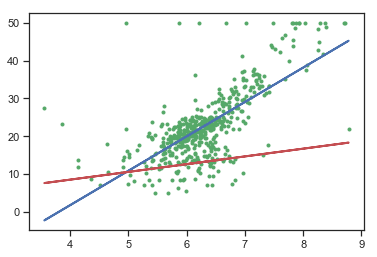

In [15]:
# Примеры использования градиентного спуска
show_gradient_descent(10, 0, 0)

b0 = -34.67062077643857 - (теоретический), -0.27688616098409397 - (градиентный спуск)
b1 = 9.10210898118031 - (теоретический), 3.6952395341558737 - (градиентный спуск)
MSE = 14.574581642017632


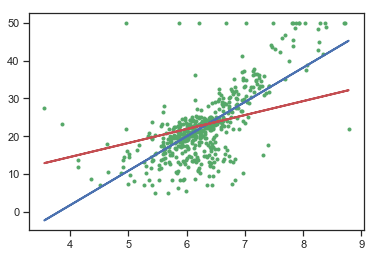

In [16]:
show_gradient_descent(1000, 0, 0)

b0 = -34.67062077643857 - (теоретический), -29.60657729498942 - (градиентный спуск)
b1 = 9.10210898118031 - (теоретический), 8.306015672780253 - (градиентный спуск)
MSE = 0.3159601254498195


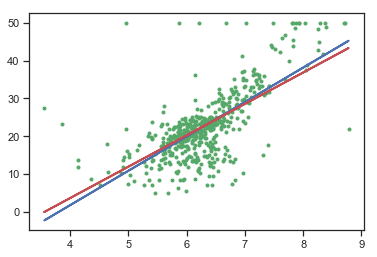

In [17]:
# Сходимость алгоритма может сильно зависеть от начальных значений
show_gradient_descent(1000, -30, 5)

### Использование класса [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) библиотеки scikit-learn.

In [18]:
# Обучим линейную регрессию и сравним коэффициенты с рассчитанными ранее
reg1 = LinearRegression().fit(x_array.reshape(-1, 1), y_array.reshape(-1, 1))
(b1, reg1.coef_), (b0, reg1.intercept_)

((9.10210898118031, array([[9.10210898]])),
 (-34.67062077643857, array([-34.67062078])))

### [Стохастический градиентный спуск](http://www.machinelearning.ru/wiki/index.php?title=%D0%A1%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%B3%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B9_%D1%81%D0%BF%D1%83%D1%81%D0%BA)

Пердполагает, что обучение на каждом шаге (эпохе) происходит не на полном наборе данных а на одном случайно выбранном примере.

В библиотеке scikit-learn используются классы:
- [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) для регрессии
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) для классификации

In [19]:
reg2 = SGDRegressor().fit(x_array.reshape(-1, 1), y_array)
(b1, reg2.coef_), (b0, reg2.intercept_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


((9.10210898118031, array([4.27254679])),
 (-34.67062077643857, array([-1.36285995])))

## Использование регуляризации в линейных моделях

[Регуляризация](https://ru.wikipedia.org/wiki/%D0%A0%D0%B5%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_(%D0%BC%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D0%BA%D0%B0)) - Это метод, который используется для борьбы с переобучением и улучшения качества моделей.

Наиболее общим методом считается [Elastic net.](https://en.wikipedia.org/wiki/Elastic_net_regularization)

В библиотеке scikit-learn используются отдельные классы для различных вариантов регуляризации:

In [20]:
from sklearn.linear_model import Lasso

In [21]:
reg3 = Lasso().fit(x_array.reshape(-1, 1), y_array)
(b1, reg3.coef_), (b0, reg3.intercept_)

((9.10210898118031, array([7.07245664])),
 (-34.67062077643857, -21.91499786473452))

In [22]:
from sklearn.linear_model import Ridge

In [23]:
reg4 = Ridge().fit(x_array.reshape(-1, 1), y_array)
(b1, reg4.coef_), (b0, reg4.intercept_)

((9.10210898118031, array([9.06574473])),
 (-34.67062077643857, -34.44208476612967))

In [24]:
from sklearn.linear_model import ElasticNet

In [25]:
reg5 = ElasticNet().fit(x_array.reshape(-1, 1), y_array)
(b1, reg5.coef_), (b0, reg5.intercept_)

((9.10210898118031, array([4.01388612])),
 (-34.67062077643857, -2.6930004271520183))

## [Нелинейная регрессия](https://ru.wikipedia.org/wiki/%D0%9D%D0%B5%D0%BB%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F)

Используется в том случае, когда данные аппроксимируются моделью, которая является более сложной, чем линейная.

В библиотеке scikit-learn реализован класс [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) для [полиномиальной регрессии.](http://www.machinelearning.ru/wiki/index.php?title=%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F)

Для комбинации классов используются [конвейры (pipeline).](https://scikit-learn.org/stable/modules/compose.html#pipeline)

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [27]:
poly_model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                       ('linear', LinearRegression(fit_intercept=False))])

In [28]:
poly_model.fit(x_array.reshape(-1, 1), y_array)

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False))])

In [29]:
poly_y_pred = poly_model.predict(x_array.reshape(-1, 1))

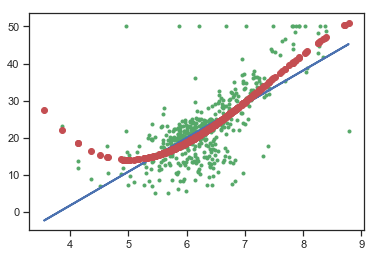

In [30]:
plt.plot(x_array, y_array, 'g.')
plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
plt.plot(x_array, poly_y_pred, 'ro')
plt.show()

In [31]:
# Степени полинома
poly_model.named_steps['linear'].coef_, poly_model.named_steps['linear'].intercept_

(array([ 241.31081379, -109.39060642,   16.49101629,   -0.74039372]), 0.0)

## [Логистическая регрессия](https://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F) 

Метод, используемый для решения задачи бинарной классификации.

Используется класс [LogisticRegression.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
iris = load_iris()

In [34]:
def convert_target_to_binary(array:np.ndarray, target:int) -> np.ndarray:
    # Если целевой признак совпадает с указанным, то 1 иначе 0
    res = [1 if x==target else 0 for x in array]
    return res

In [35]:
bin_iris_y = convert_target_to_binary(iris.target, 2)

In [36]:
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(
    iris.data, bin_iris_y, test_size=0.5, random_state=1)

In [37]:
cl1 = LogisticRegression()

In [38]:
cl1.fit(iris_X_train, iris_y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:
pred_iris_y_test = cl1.predict(iris_X_test)

In [40]:
accuracy_score(iris_y_test, pred_iris_y_test)

0.9866666666666667

In [41]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [42]:
print_accuracy_score_for_classes(iris_y_test, pred_iris_y_test)

Метка 	 Accuracy
0 	 0.9791666666666666
1 	 1.0


# Дополнительные источники
- https://habr.com/ru/post/307004/
- https://habr.com/ru/company/ods/blog/323890/
- http://www.levvu.narod.ru/Machine_Learning_LTU_8.pdf

